# ATSAC Loop Detector Data in Google BigQuery

We would like to evaluate the ergonomics and cost-effectiveness of
storing ATSAC loop detector data. The data can get quite large,
with thousands of detectors reporting every thirty seconds.

We have loaded several days of data into Google BigQuery,
which we will then use in a brief analysis.


## Setup

First, we make some relevant imports:

In [1]:
import functools

import altair
import contextily
import geopandas
import matplotlib.pyplot as plt
import pandas
import shapely

In order to make a request to Google BigQuery using the PyData stack,
I need to install `pandas-gbq` and `pydata-google-auth`:

In [2]:
%pip install pydata-google-auth pandas-gbq pyarrow>=0.15.0

Note: you may need to restart the kernel to use updated packages.


I authenticated with my Google account by running the following in a terminal,
and following the instructions:
```bash
python -m pydata_google_auth login ~/keys/google-credentials.json
```
The resulting credentials are stored to `~/keys/google-credentials.json`,
and I can read them in for this query using the following:

In [3]:
import pydata_google_auth
credentials = pydata_google_auth.load_user_credentials(
    "./keys/google-credentials.json"
)

## Making a Query

Let's assemble a query for all the detectors that fall within the Arts District/Little Tokyo neighborhood.
We first read in that geometry data from the LA GeoHub, and extract the shape we want:

In [4]:
NEIGHBORHOOD_URL = (
    "https://opendata.arcgis.com/datasets/674f80b8edee4bf48551512896a1821d_0.geojson"
)
neighborhoods = geopandas.read_file(NEIGHBORHOOD_URL)

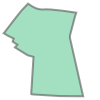

In [5]:
historic_cultural = neighborhoods[neighborhoods.Name == "Historic Cultural"].iloc[0]
historic_cultural

def _to_2d(x, y, z):
    return tuple(filter(None, [x, y]))

shape = shapely.ops.transform(_to_2d, historic_cultural.geometry)
shape

We can now use this shape to make a query to Google BigQuery,
and see how long it takes to run:

In [6]:
%%time

query = f"""
SELECT ID,TIMESTAMP,LAT,LON,VOL FROM `ita-datalakepoc.ATSAC.det_data_20200401`
WHERE ST_WITHIN(ST_GEOGPOINT(LON, LAT), ST_GEOGFROMTEXT('{shape.wkt}'))
"""

df = pandas.read_gbq(
    query,
    project_id="ita-datalakepoc",
    credentials=credentials,
)

Downloading: 100%|██████████| 460800/460800 [00:18<00:00, 25307.75rows/s]

CPU times: user 7.99 s, sys: 656 ms, total: 8.64 s
Wall time: 5min 2s


Let's inspect this result:

In [7]:
df

,ID,TIMESTAMP,LAT,LON,VOL
0,3404481182379,2020-03-31 00:00:30+00:00,34.044814,-118.237998,0
1,3404481182379,2020-03-31 00:01:00+00:00,34.044814,-118.237998,0
2,3404481182379,2020-03-31 00:01:30+00:00,34.044814,-118.237998,0
3,3404481182379,2020-03-31 00:02:00+00:00,34.044814,-118.237998,0
4,3404481182379,2020-03-31 00:02:30+00:00,34.044814,-118.237998,0
...,...,...,...,...,...
460795,3405151182399,2020-03-31 23:58:00+00:00,34.051592,-118.239965,0
460796,3405151182399,2020-03-31 23:58:30+00:00,34.051592,-118.239965,1
460797,3405151182399,2020-03-31 23:59:00+00:00,34.051592,-118.239965,0
460798,3405151182399,2020-03-31 23:59:30+00:00,34.051592,-118.239965,0


## Plotting the results

Okay, that's a lot of data, let's get a daily aggregate for each detector,
and visualize the results:

In [8]:
volume = df.groupby("ID").agg({
    "LAT": "first",
    "LON": "first",
    "VOL": "sum",
})
gdf = geopandas.GeoDataFrame(
    volume,
    crs={"init": "epsg:4326"},
    geometry=geopandas.points_from_xy(volume.LON, volume.LAT),
).drop(columns=["LAT", "LON"])

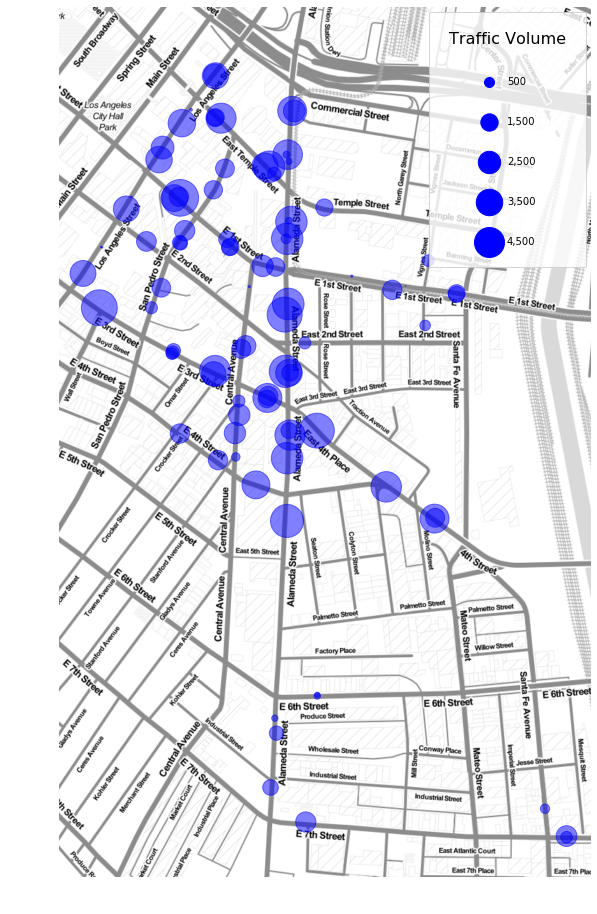

In [9]:
WEB_MERCATOR = 3857
SCALE=5
fig, ax = plt.subplots(figsize=(16,16))
gdf.to_crs(epsg=WEB_MERCATOR).plot(
    alpha=0.5,
    color="blue",
    ax=ax,
    markersize=gdf.VOL/SCALE,
    legend=True,
)
steps = range(100, 1000, 200)
plt.legend(
    [ax.scatter([],[], s=y, color="blue", label=y) for y in steps],
    [f"{y*SCALE:,}" for y in steps],
    labelspacing=3,
    borderpad=2,
    title="Traffic Volume",
    title_fontsize=16,
    fancybox=True,
    loc="upper right",
)
contextily.add_basemap(ax, url=contextily.sources.ST_TONER_LITE)
ax.set_axis_off()

Let's also create a time series chart of the volume for the ten most active detectors:

In [10]:
highest_traffic = gdf.sort_values("VOL", ascending=False).head(10)
tseries = df[df.ID.isin(highest_traffic.index)]
tseries = tseries.groupby(["ID", pandas.Grouper(key="TIMESTAMP", freq="H")]).agg({
    "VOL": "sum",
}).reset_index().rename(columns={
    "ID": "Detector",
    "TIMESTAMP": "Time",
    "VOL": "Volume",
})

# Fix apparently wrongly-specified timezone
tseries = tseries.assign(
    Time=tseries.Time.dt.tz_convert(None).dt.tz_localize("US/Pacific")
)

In [11]:
altair.Chart(tseries).mark_line().encode(
    x="Time:T",
    y="Volume:Q",
    color="Detector:N",
)

alt.Chart(...)

## Assembling a more complex query

For many people familiar with the Python data stack, writing raw SQL queries can
be an uncomfortable experience (*waves*). One tool that can help assemble them
is the `ibis` library, which provides a pandas-like syntax for executing queries
against SQL-like backends. `ibis` has a BigQuery backend which we can use to assemble a query.

First, let's connect to BigQuery using the same credentials as above:

In [12]:
import ibis.bigquery

con = ibis.bigquery.connect(
    project_id="ita-datalakepoc",
    dataset_id="ita-datalakepoc.ATSAC",
    credentials=credentials,
)

To verify the connection, let's list the tables:

In [13]:
con.list_tables()

['det_data_20200311',
 'det_data_20200330',
 'det_data_20200331',
 'det_data_20200401',
 'det_data_20200402',
 'det_data_20200403',
 'det_data_20200404',
 'det_data_20200405',
 'det_data_part']

Let's look at data over a week from 3/30 to 4/05. We can create a list of target
tables like such:

In [14]:
tables = [
    con.table(t)[["ID", "LON", "LAT", "TIMESTAMP", "VOL"]] for t in con.list_tables()
    if t != "det_data_20200311" and t != "det_data_part"
]

With the list of targets, we can `UNION` them into a single meta-table with all the data for those dates:

In [15]:
union = functools.reduce(
    lambda x,y: x.union(y) if x is not None else y,
    tables,
    None,
)

`ibis` has a nice graphviz visualization of its queries. Let's take a look at our union table:

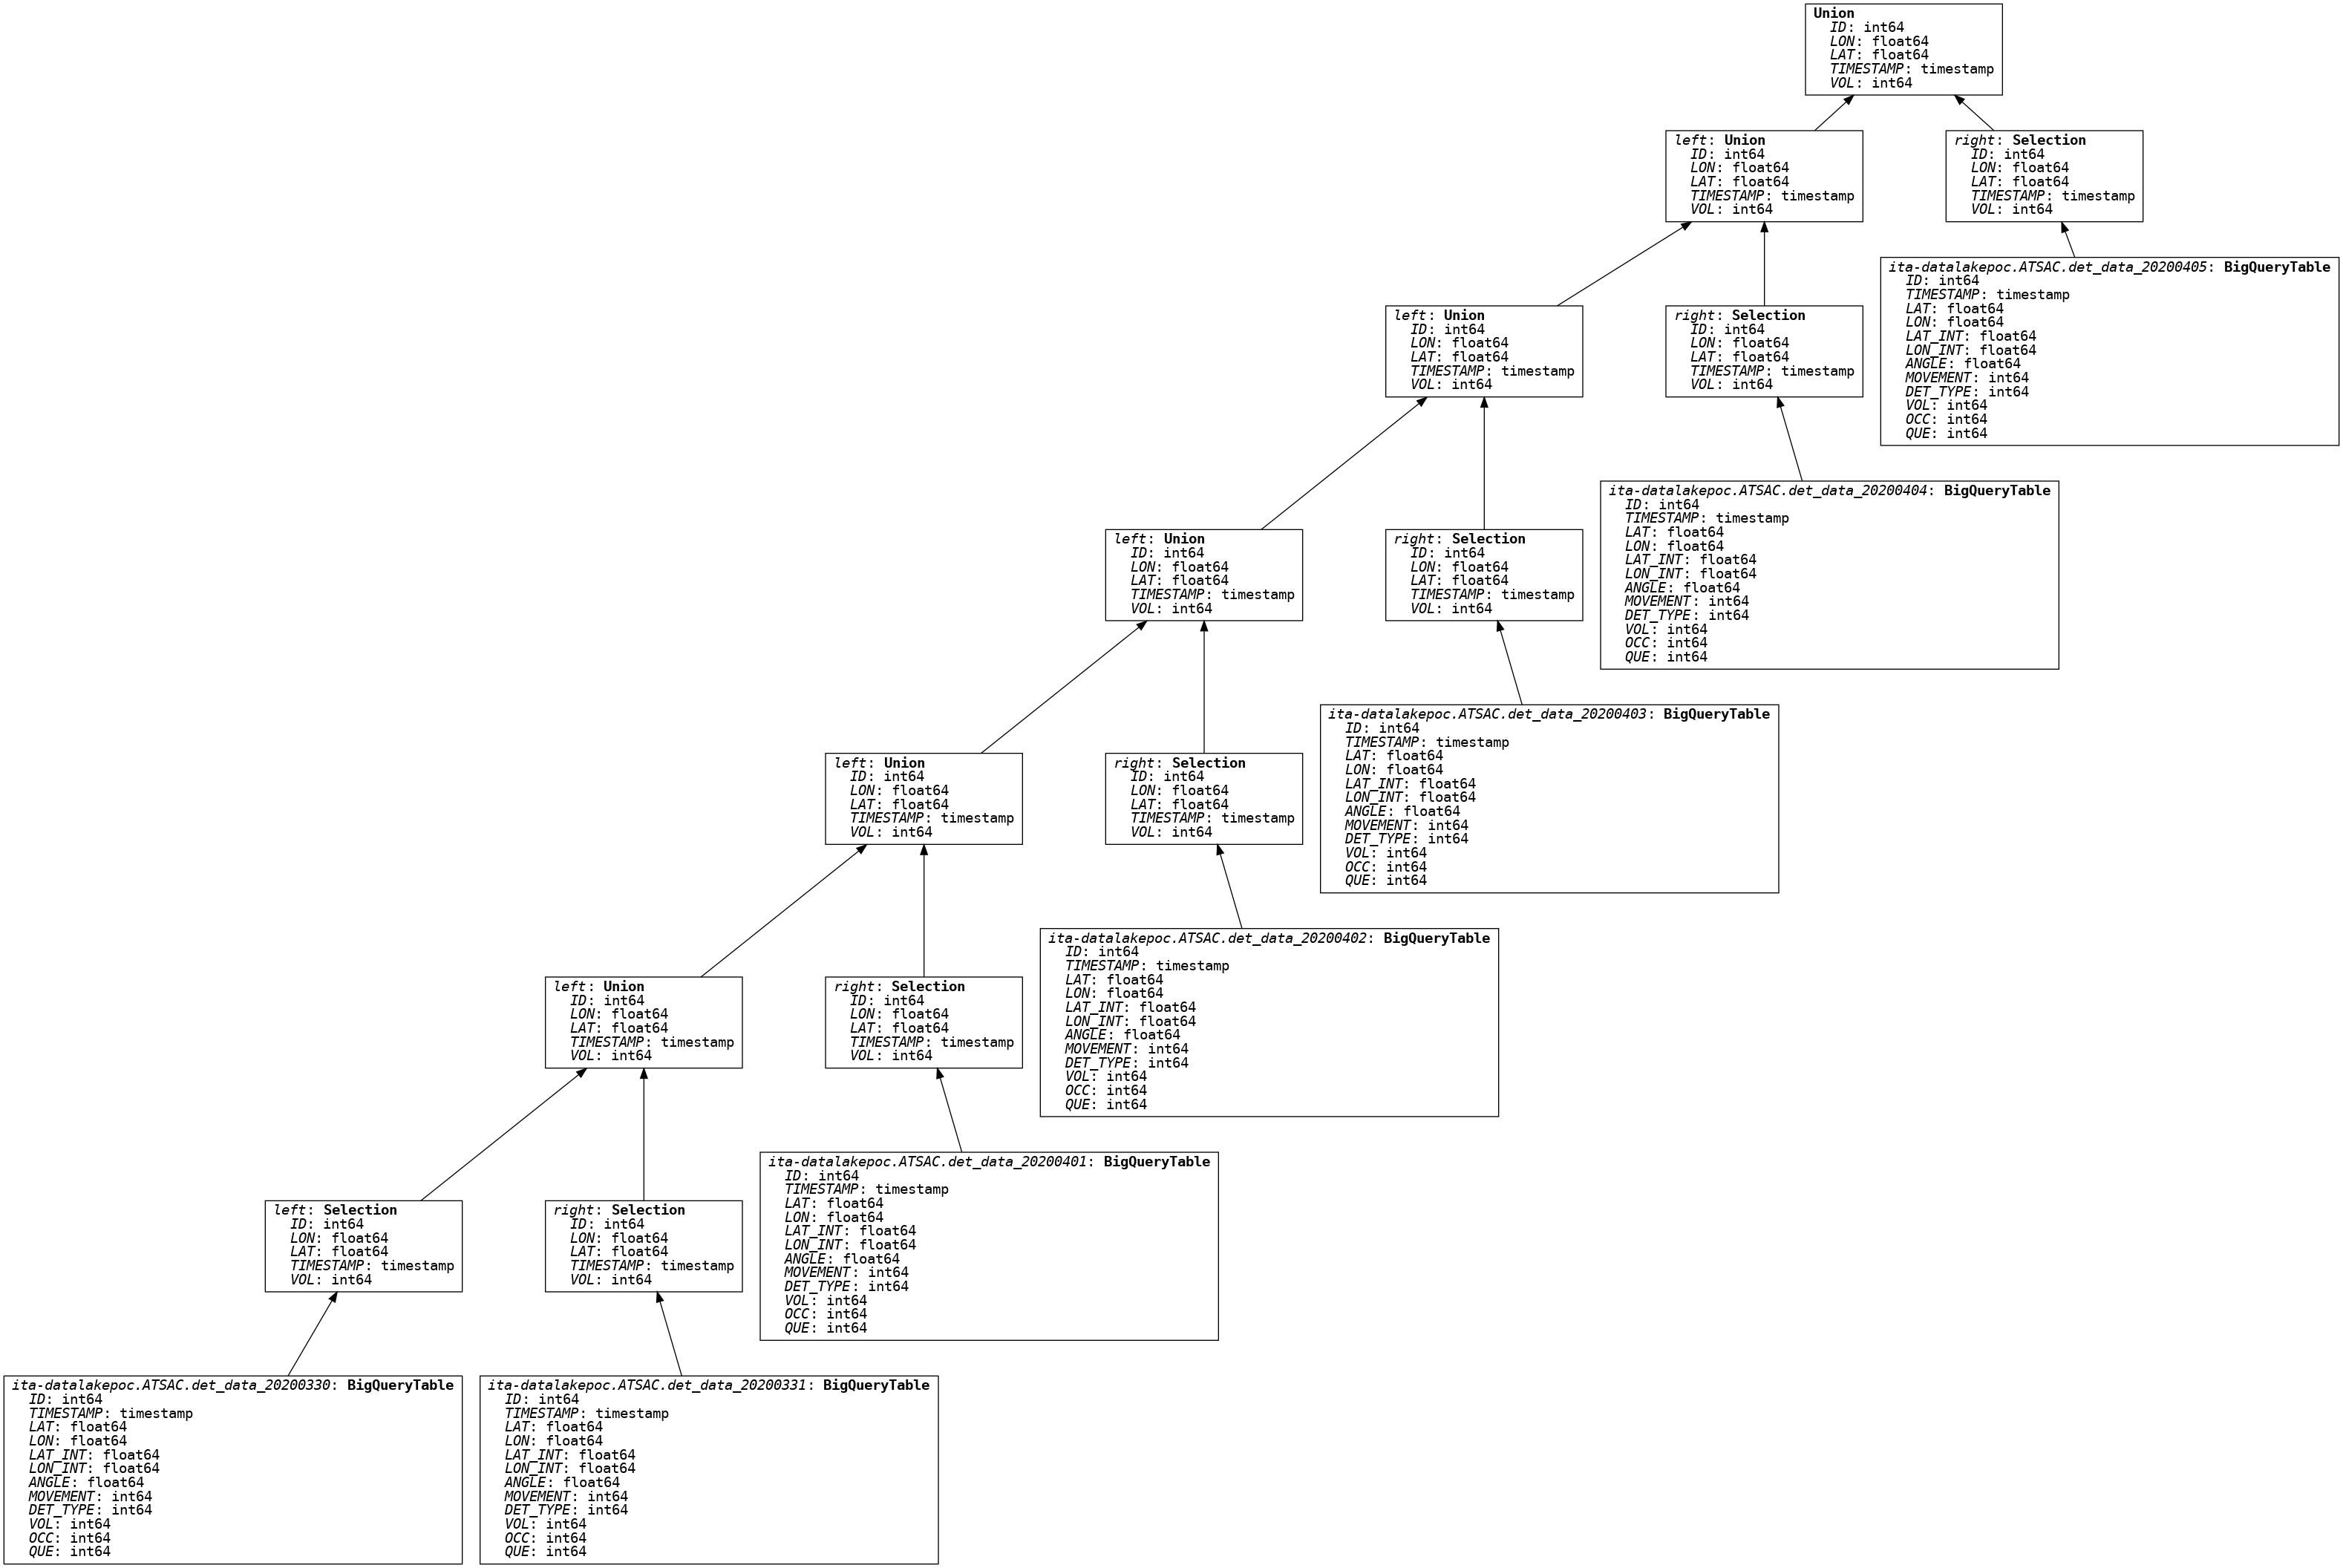

In [16]:
union

Now let's ask a question of the data. Specifically, what are the loop detectors that
receive the most traffic overnight? We can filter the table by the hours in
a typical graveyard shift, and aggregate them by detector id as such:

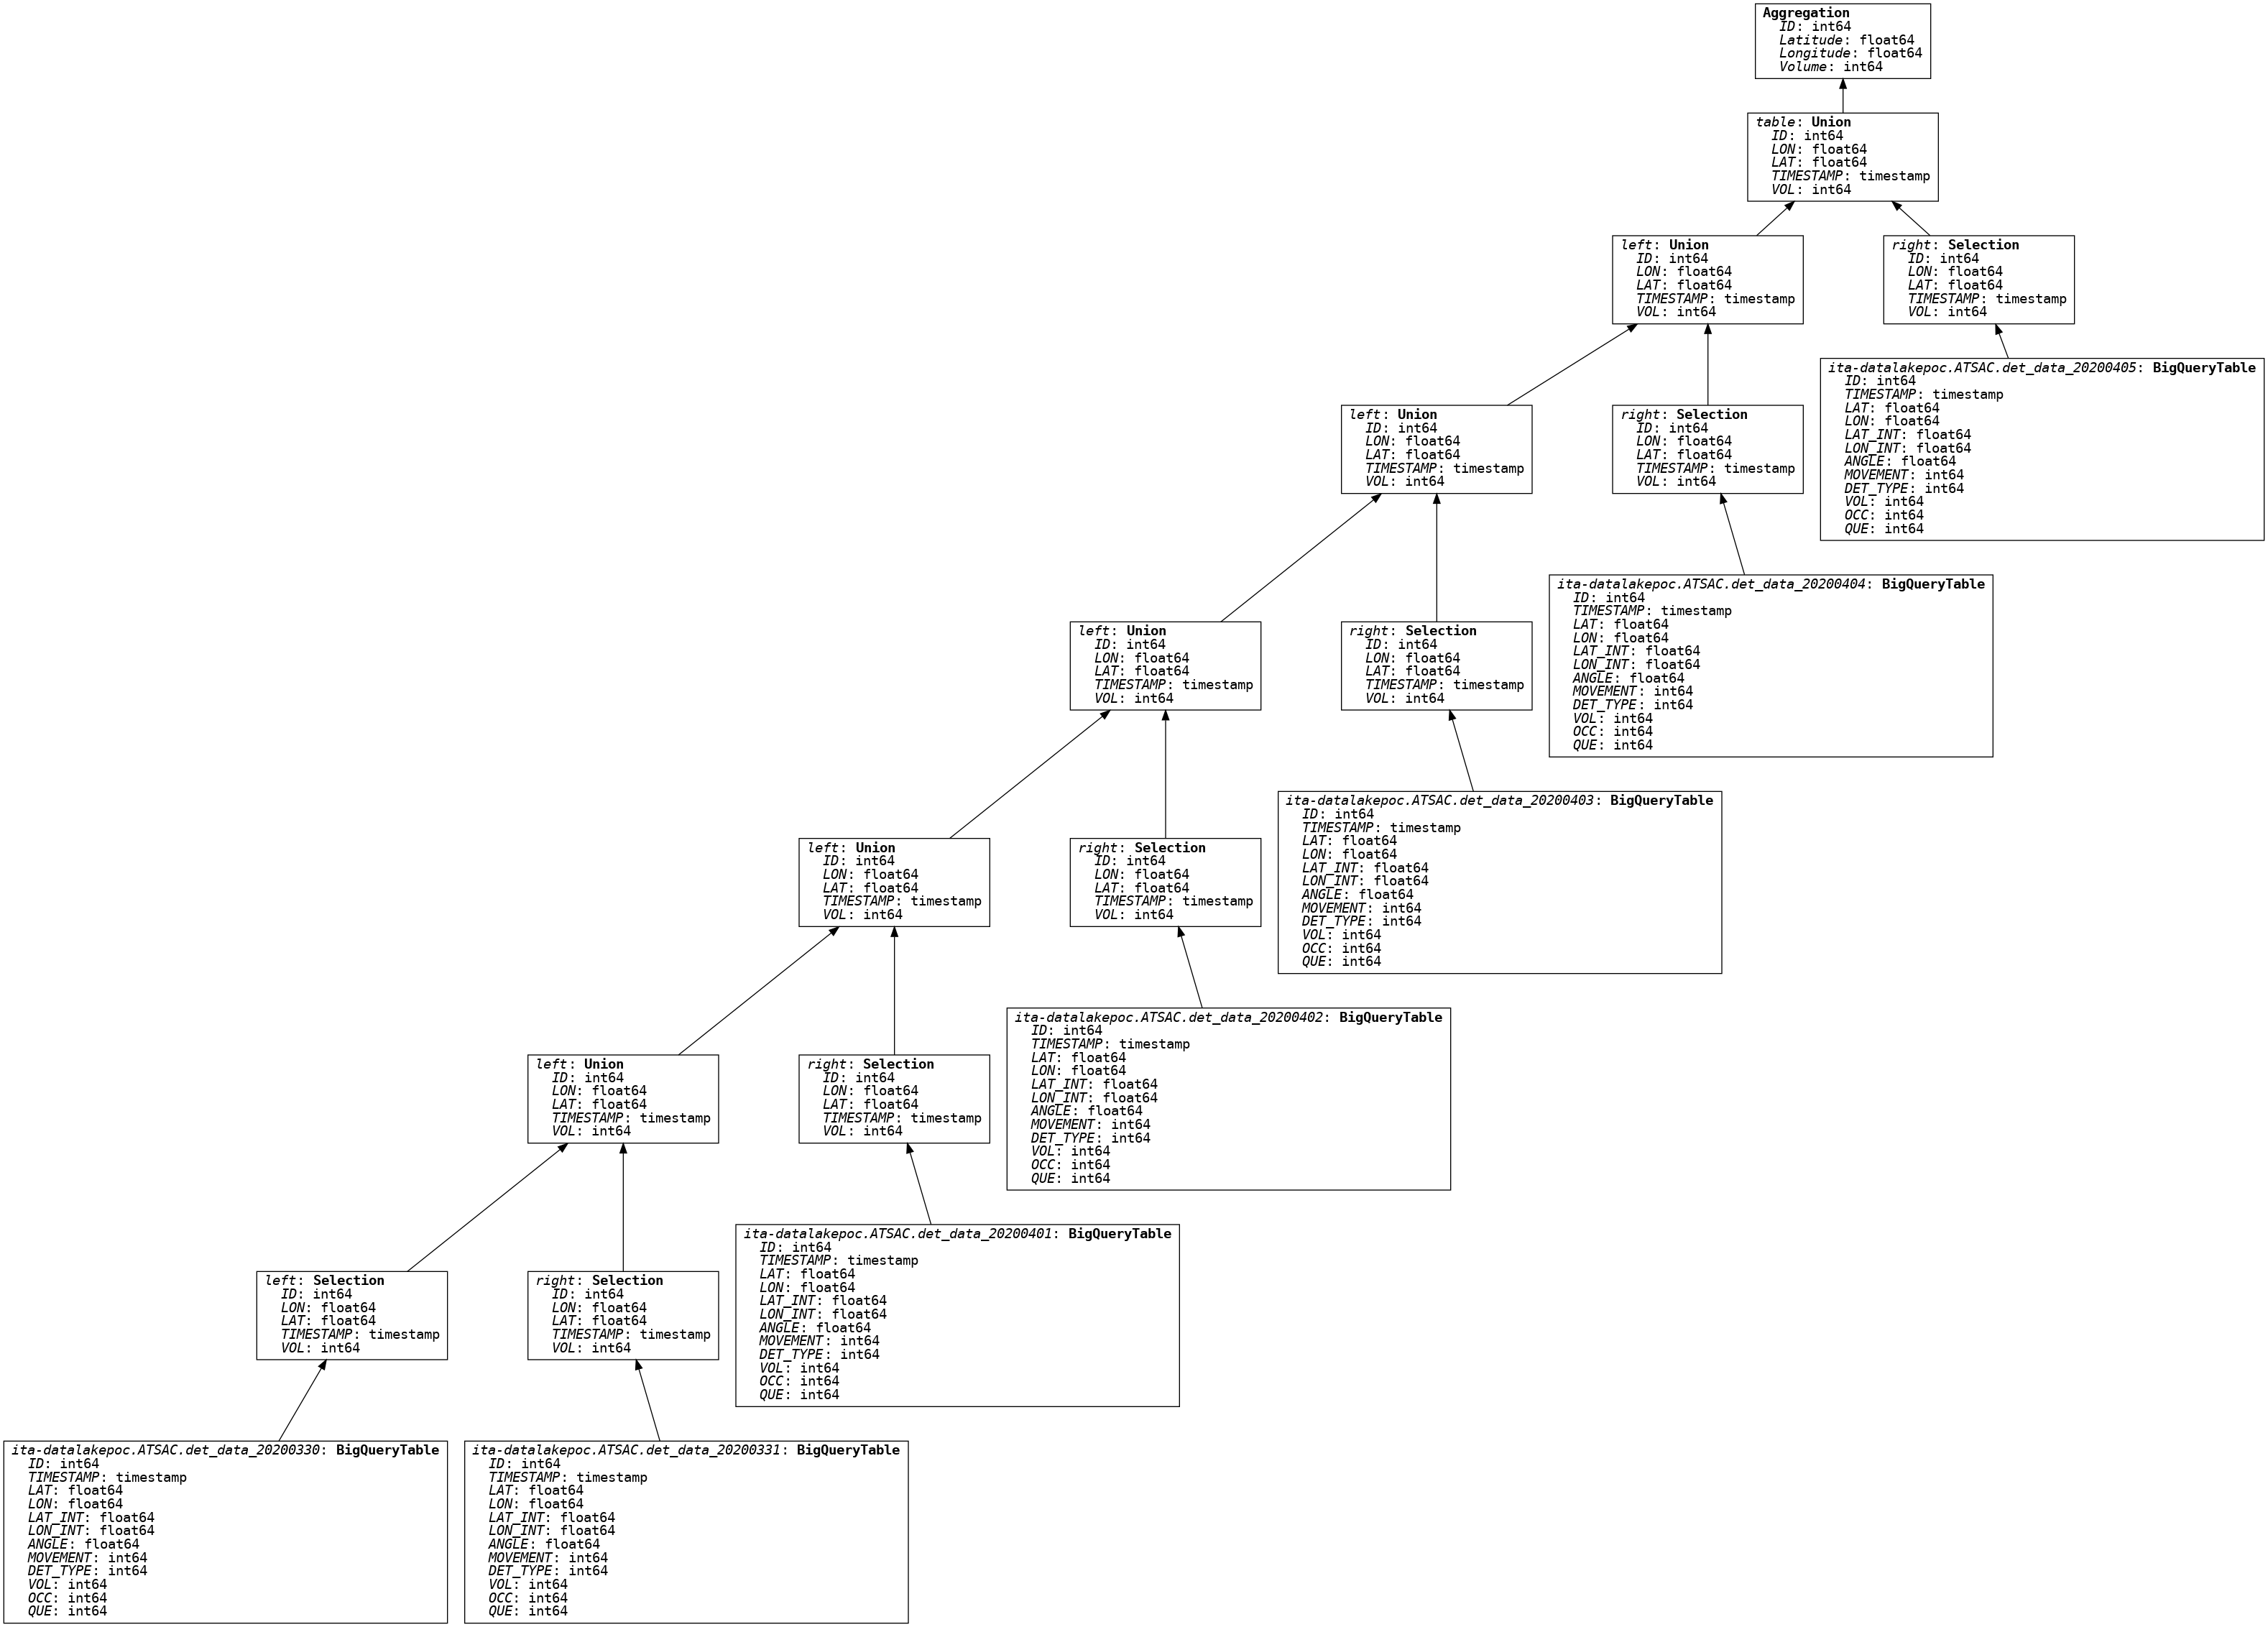

In [17]:
graveyard = union[
    (union.TIMESTAMP.hour() > 10) |
    (union.TIMESTAMP.hour() < 6)
]
graveyard_volume = graveyard.groupby(graveyard.ID).aggregate([
    graveyard.LAT.max().name("Latitude"),
    graveyard.LON.max().name("Longitude"),
    graveyard.VOL.sum().name("Volume"),
])
graveyard_volume

As of now, we still have not executed our query.
But we *can* inspect the SQL that is generated by the above expression:

In [24]:
display({"text/plain": graveyard_volume.compile()}, raw=True)

SELECT t0.`ID`, max(t0.`LAT`) AS `Latitude`, max(t0.`LON`) AS `Longitude`,
       sum(t0.`VOL`) AS `Volume`
FROM (
  SELECT `ID`, `LON`, `LAT`, `TIMESTAMP`, `VOL`
  FROM `ita-datalakepoc.ATSAC.det_data_20200330`
  UNION ALL
  SELECT `ID`, `LON`, `LAT`, `TIMESTAMP`, `VOL`
  FROM `ita-datalakepoc.ATSAC.det_data_20200331`
  UNION ALL
  SELECT `ID`, `LON`, `LAT`, `TIMESTAMP`, `VOL`
  FROM `ita-datalakepoc.ATSAC.det_data_20200401`
  UNION ALL
  SELECT `ID`, `LON`, `LAT`, `TIMESTAMP`, `VOL`
  FROM `ita-datalakepoc.ATSAC.det_data_20200402`
  UNION ALL
  SELECT `ID`, `LON`, `LAT`, `TIMESTAMP`, `VOL`
  FROM `ita-datalakepoc.ATSAC.det_data_20200403`
  UNION ALL
  SELECT `ID`, `LON`, `LAT`, `TIMESTAMP`, `VOL`
  FROM `ita-datalakepoc.ATSAC.det_data_20200404`
  UNION ALL
  SELECT `ID`, `LON`, `LAT`, `TIMESTAMP`, `VOL`
  FROM `ita-datalakepoc.ATSAC.det_data_20200405`
) t0
WHERE (EXTRACT(hour from t0.`TIMESTAMP`) > 10) OR (EXTRACT(hour from t0.`TIMESTAMP`) < 6)
GROUP BY 1

Now, let's execute the query to get back an in-memory dataframe:

In [18]:
%%time
graveyard_df = graveyard_volume.execute(limit=None)

CPU times: user 194 ms, sys: 36.3 ms, total: 231 ms
Wall time: 2min 26s


Okay! Now we have the aggregated detector data for all the detectors citywide
between the hours of 10 PM and 6 AM. Let's visualize the five hundred detectors
with the most activity during the graveyard shift:

In [19]:
gdf = geopandas.GeoDataFrame(
    graveyard_df,
    crs={"init": "epsg:4326"},
    geometry=geopandas.points_from_xy(graveyard_df.Longitude, graveyard_df.Latitude),
).drop(columns=["Latitude", "Longitude"])

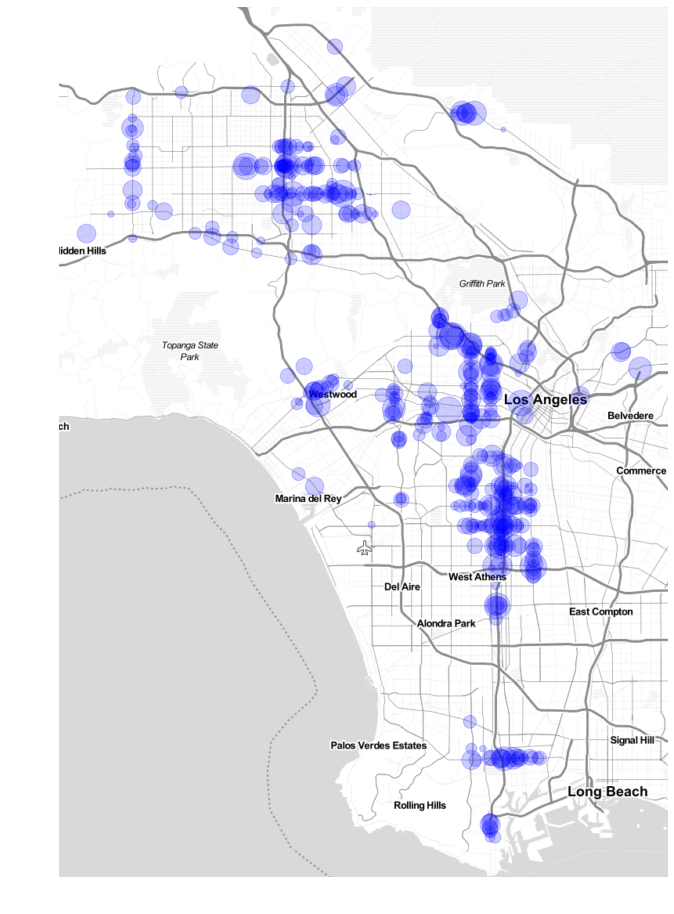

In [20]:
fig, ax = plt.subplots(figsize=(16,16))
gdf.sort_values("Volume", ascending=False).head(500).to_crs(epsg=WEB_MERCATOR).plot(
    alpha=0.2,
    color="blue",
    ax=ax,
    markersize=gdf.Volume/100.,
    legend=True,
)
contextily.add_basemap(ax, url=contextily.sources.ST_TONER_LITE)
ax.set_axis_off()

As we can see, activity seems to be concentrated in a few neighborhoods,
including Chatsworth, Van Nuys, Hollywood, Koreatown, South LA, and Wilmington.